In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

import metpy

import dask.dataframe as dd

from dask import delayed
from dask.distributed import Client

from sklearn.linear_model import LinearRegression

# AOD-AERONET

In [2]:
useful_aeronet_files = pd.read_csv('data/usefule_aeronet_files.csv')['Files'].values

In [3]:
def read_aeronet_csv(filename, **kwargs):
    df = pd.read_csv(filename, skiprows=5, header=1, encoding_errors='replace', **kwargs)
    df['AOD_550nm'] = df['AOD_675nm'] * (550 / 675) ** -df['440-675_Angstrom_Exponent']
    df['Datetime'] = pd.to_datetime(df['Date(dd:mm:yyyy)'] + ' ' + df['Time(hh:mm:ss)'], format='%d:%m:%Y %H:%M:%S')
    df = df.drop(['Date(dd:mm:yyyy)', 'Time(hh:mm:ss)'], axis=1)
    df.set_index('Datetime', inplace=True)
    return df

In [4]:
modis = pd.read_csv('data/7km_averaged_aod.csv')
modis['Dates'] = pd.to_datetime(modis['Dates'])
aeronet = [delayed(read_aeronet_csv)(i, na_values=["-999.000000"]) for i in useful_aeronet_files]

/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_90623/3737345107.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
/usr/local/Caskroom/miniconda/base/envs/pm/lib/python3.9/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


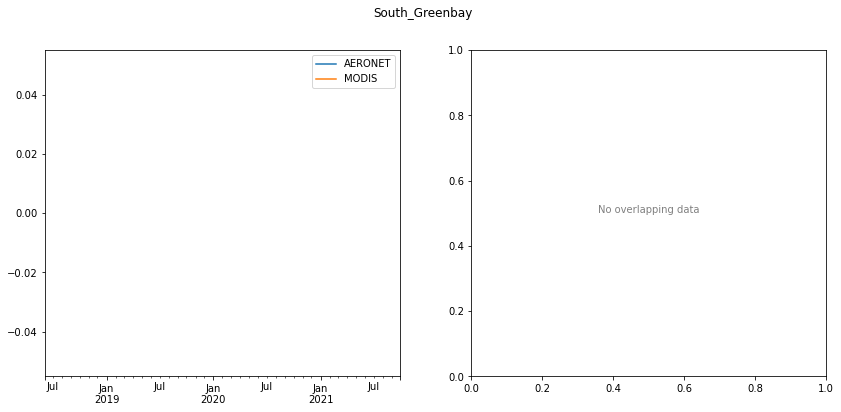

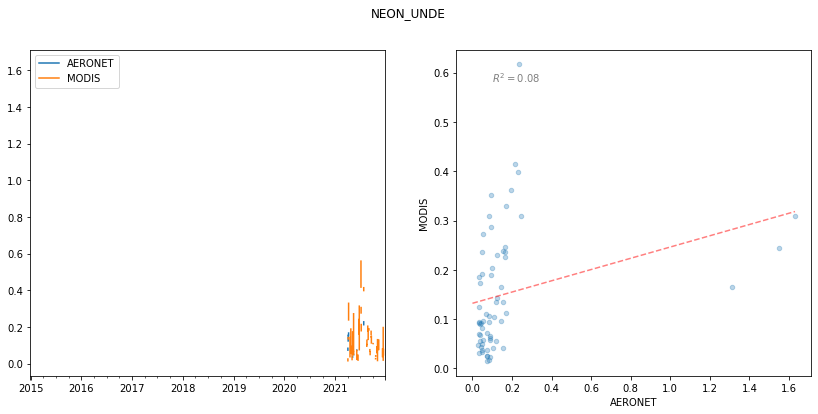

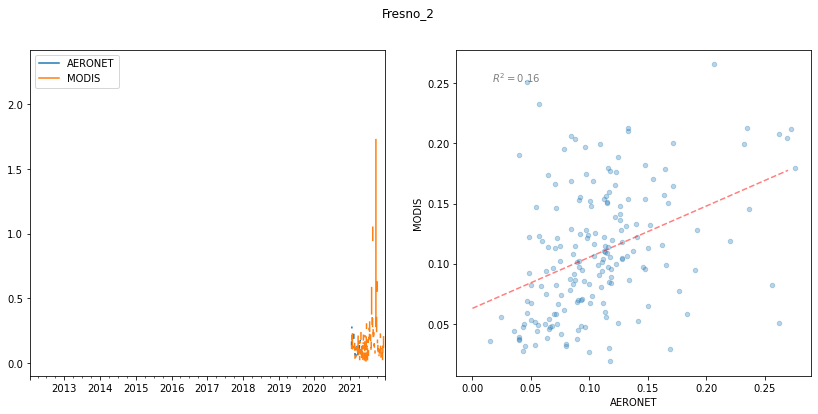

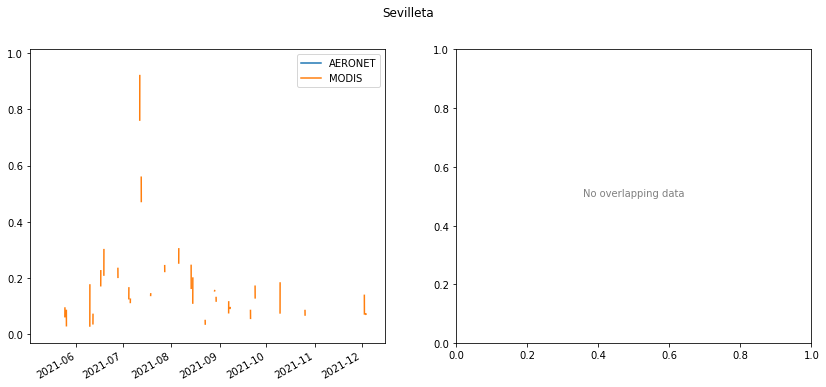

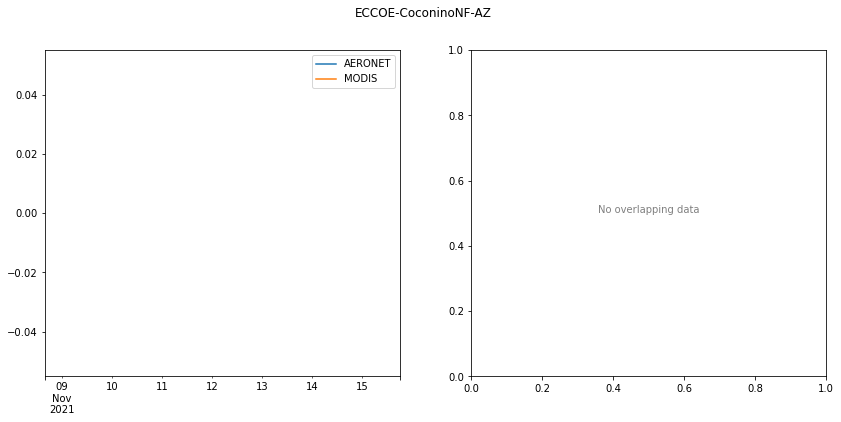

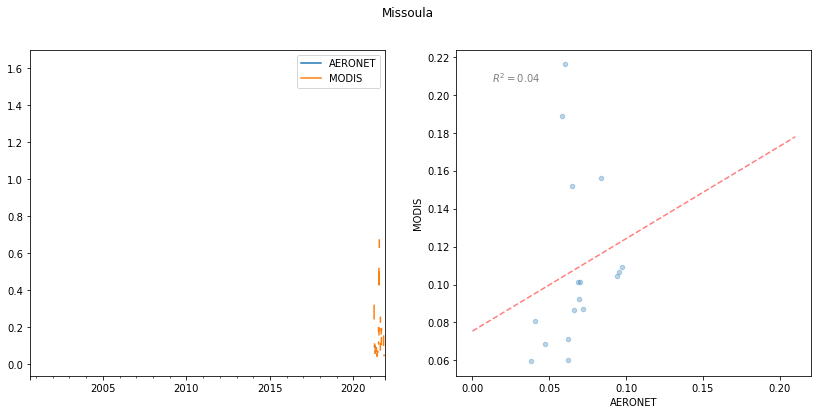

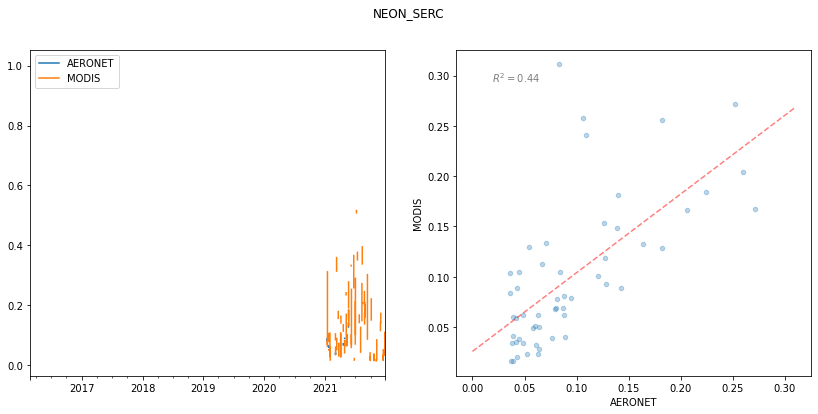

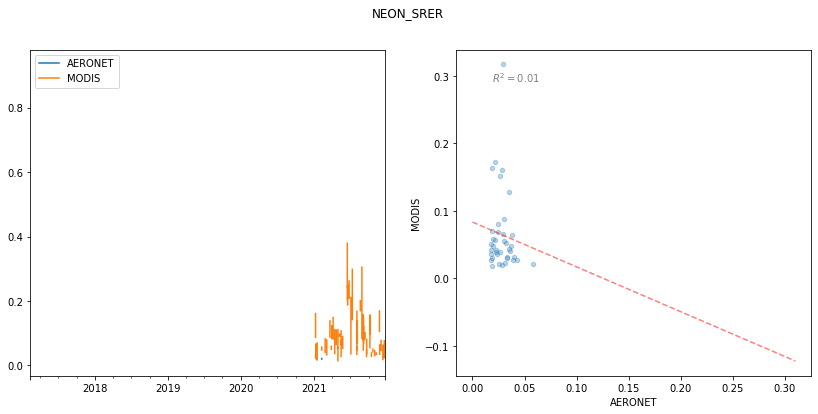

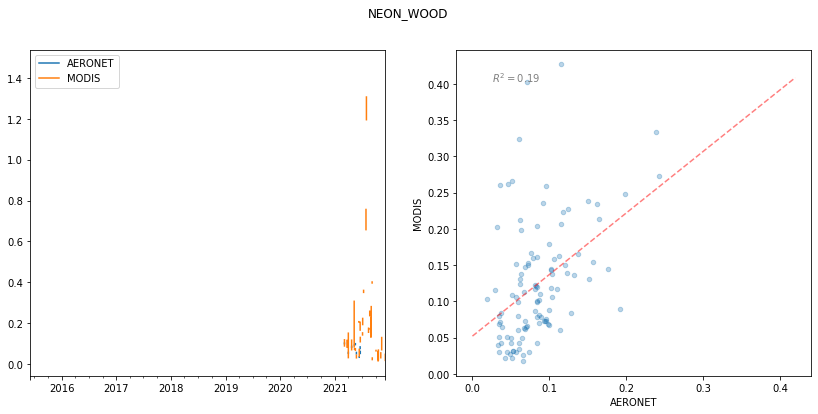

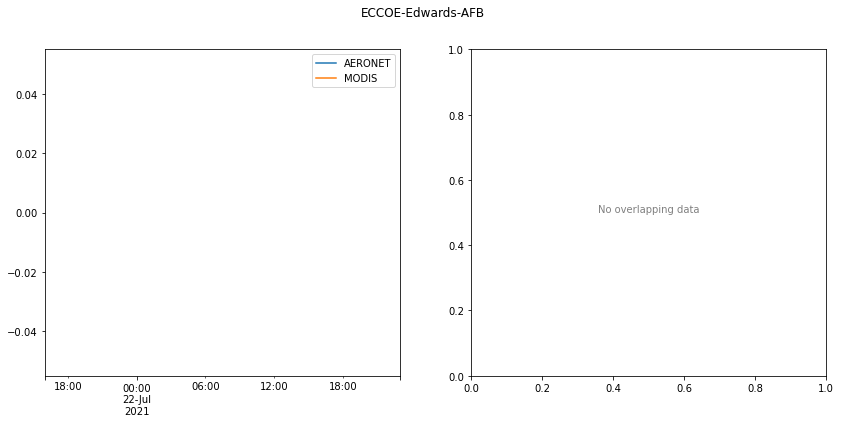

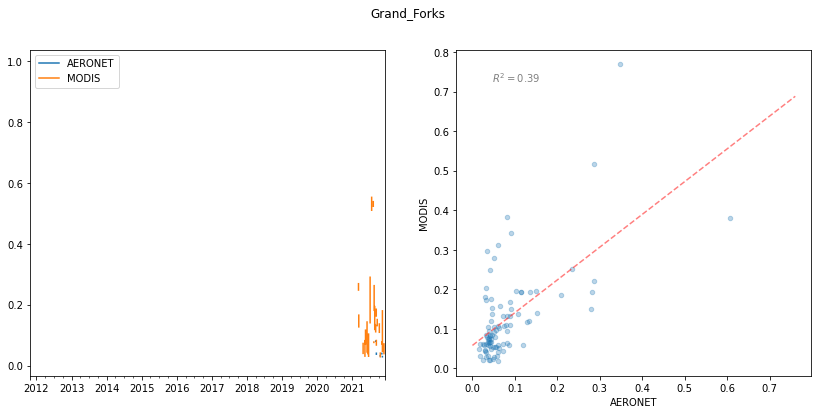

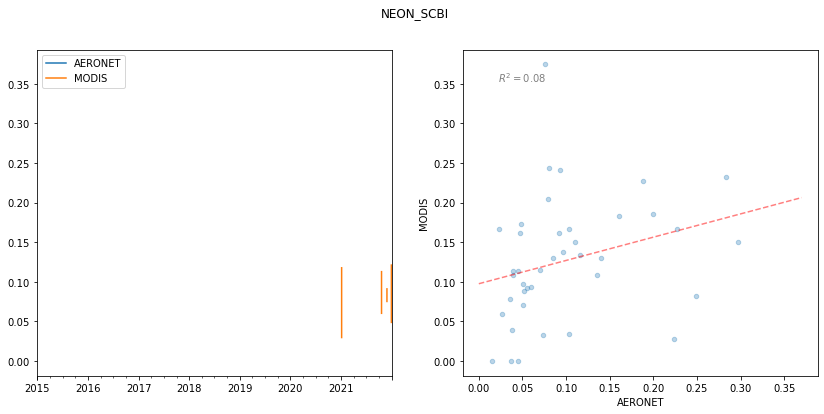

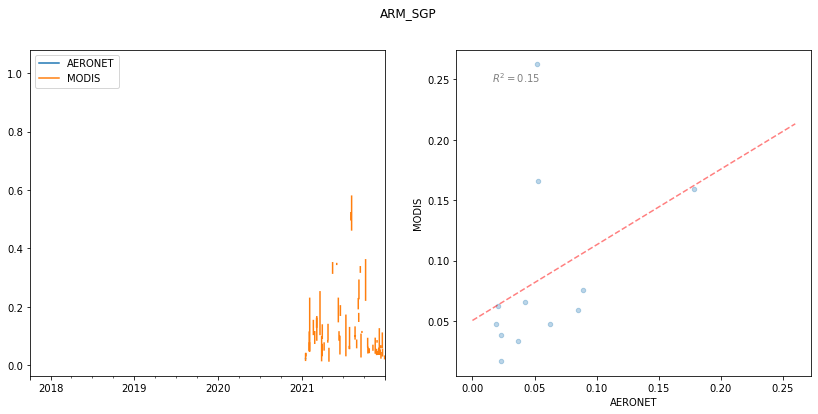

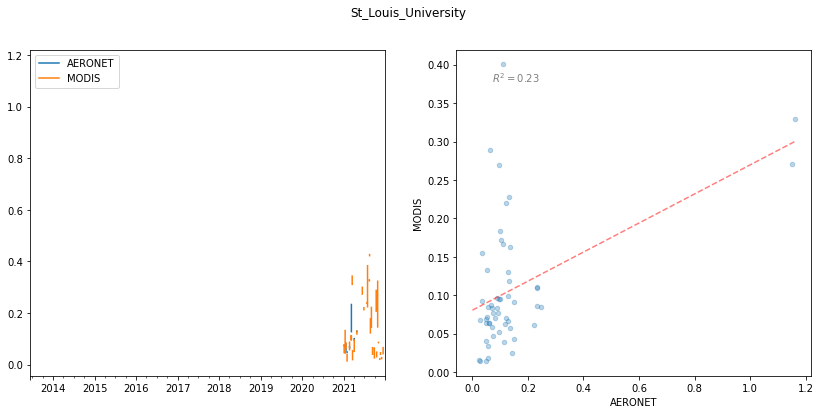

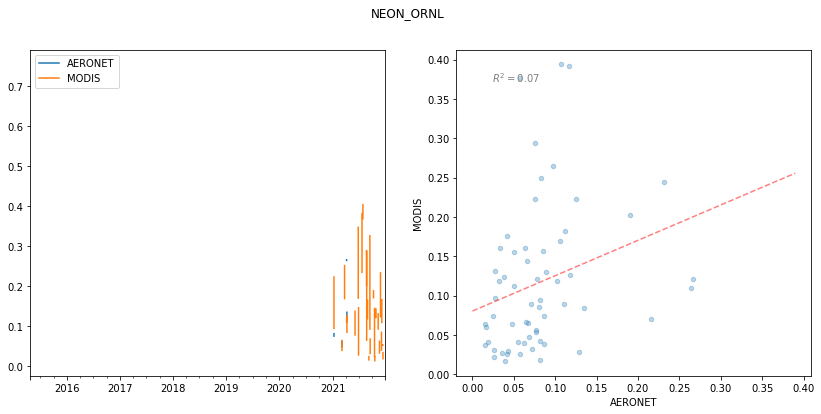

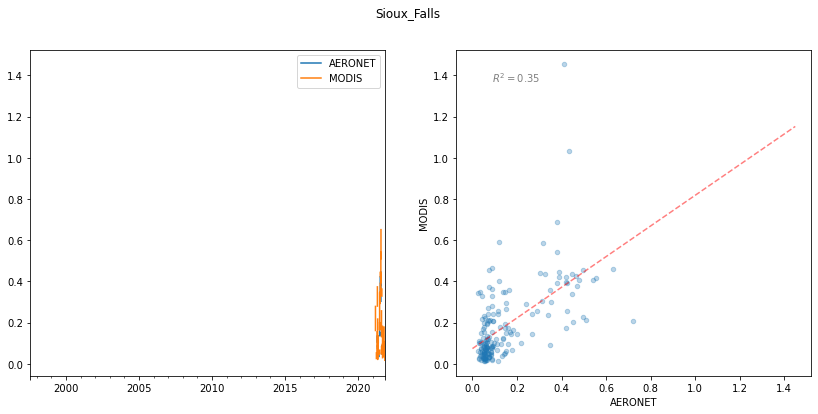

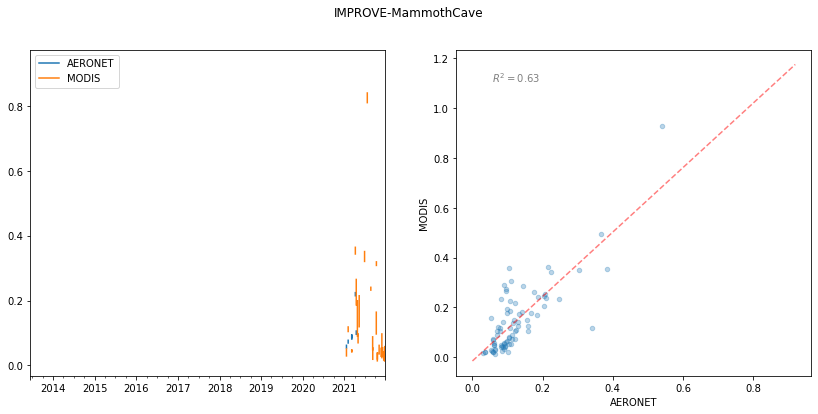

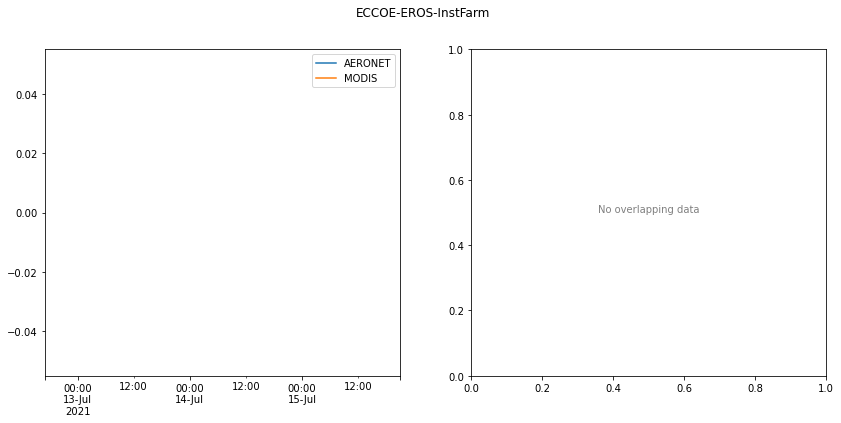

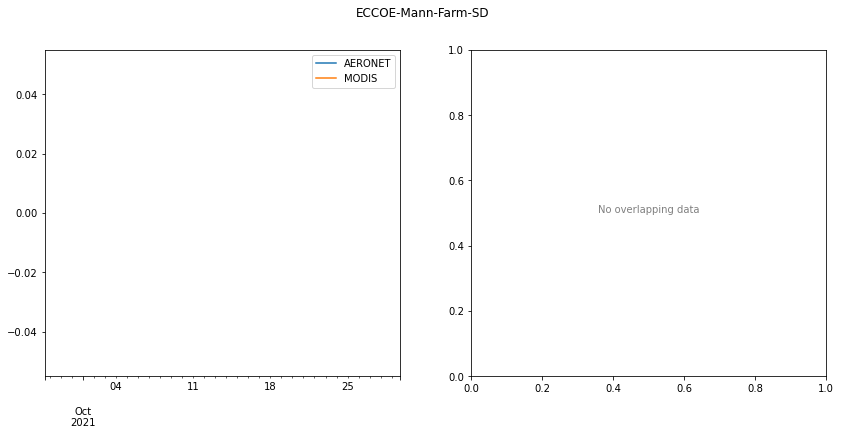

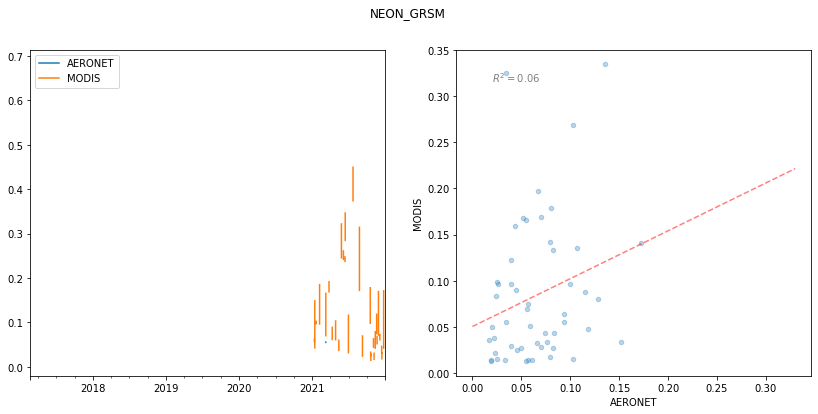

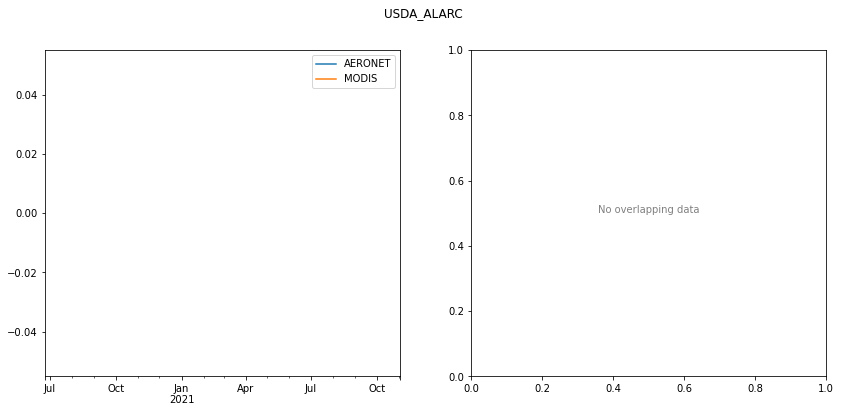

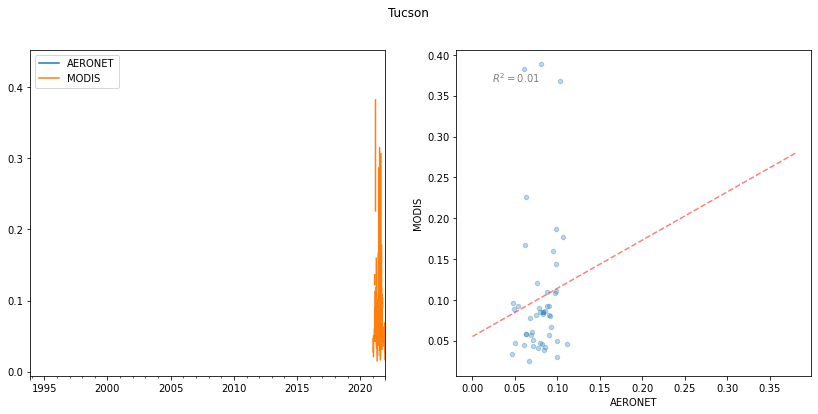

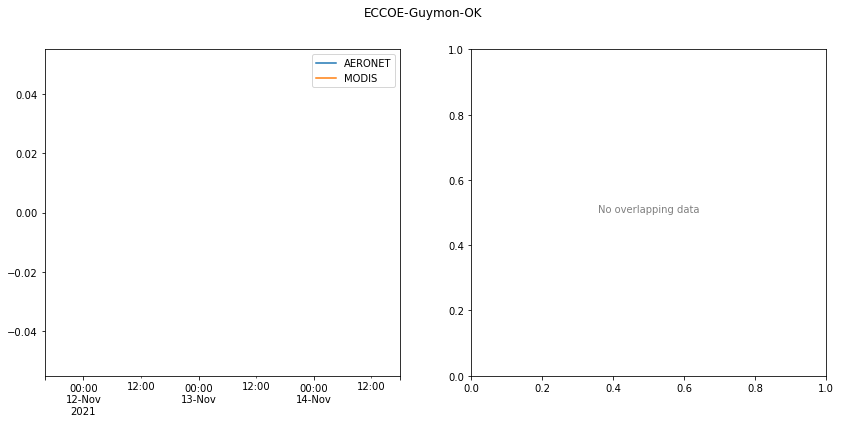

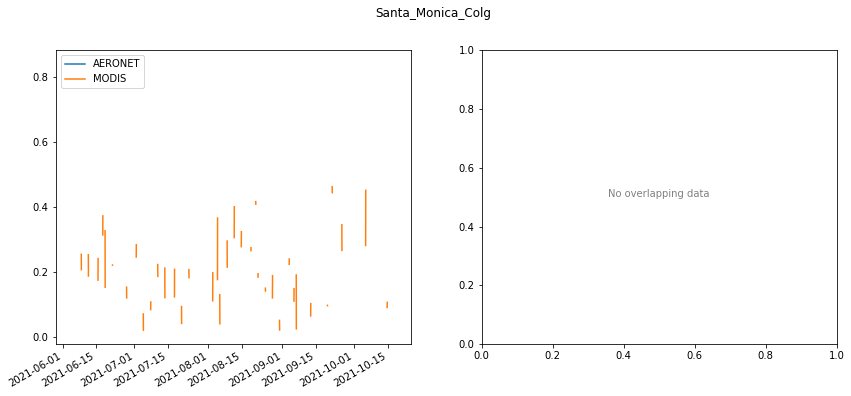

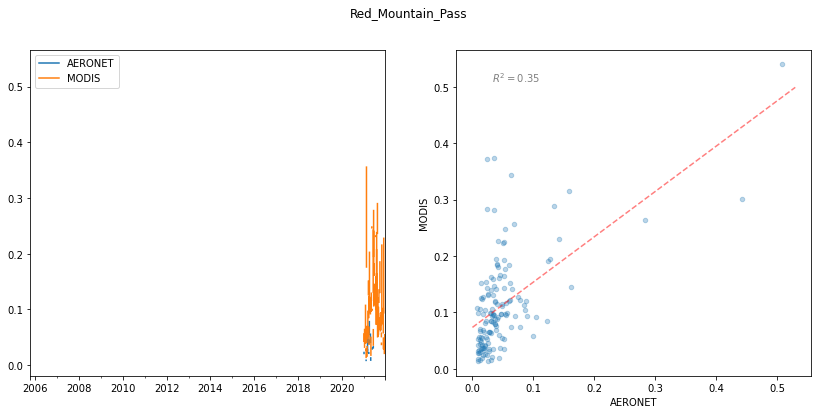

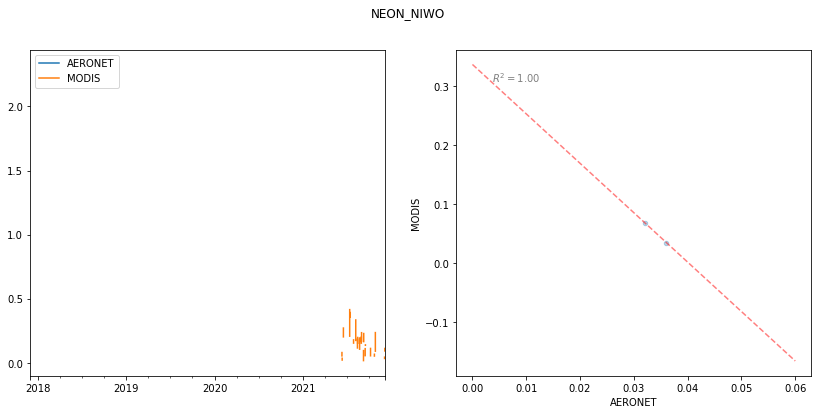

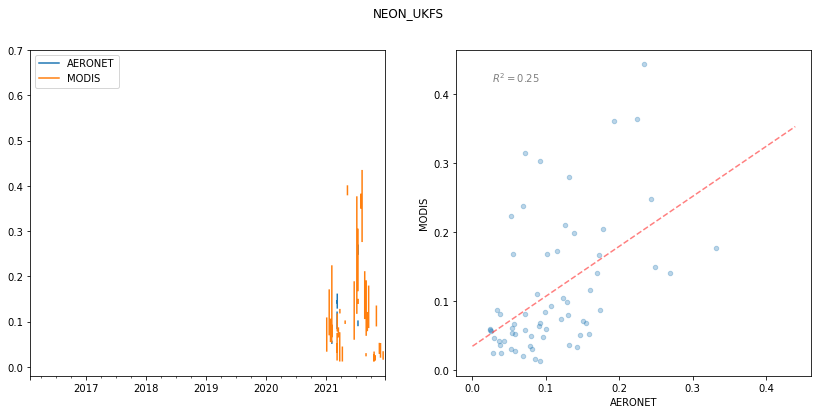

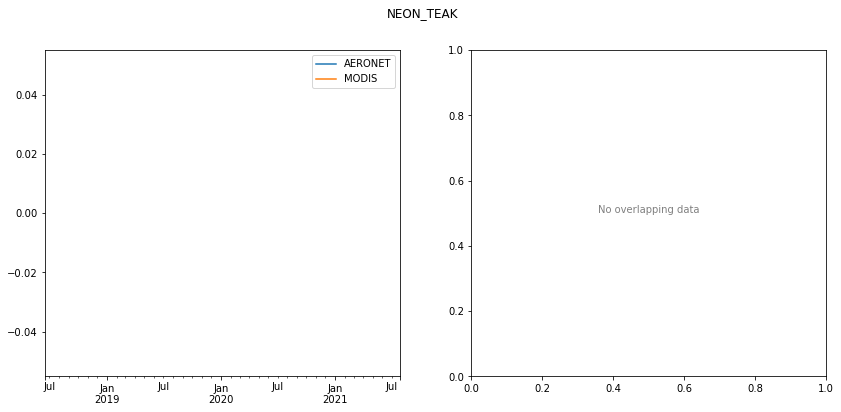

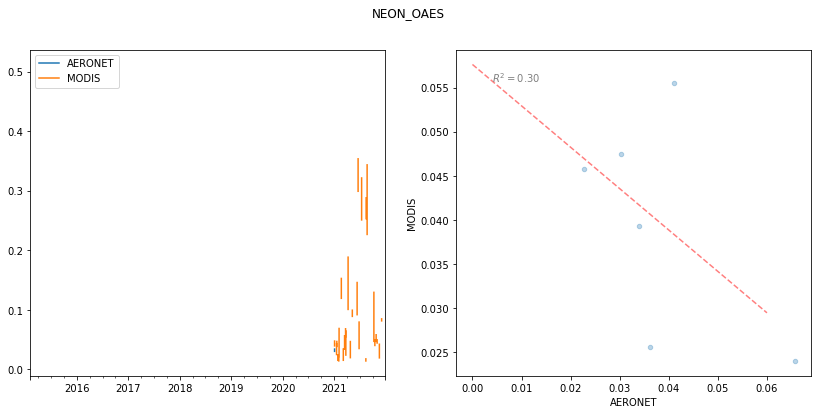

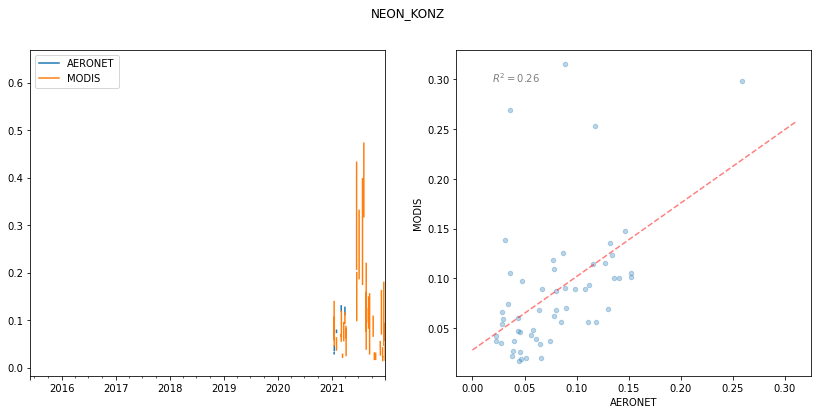

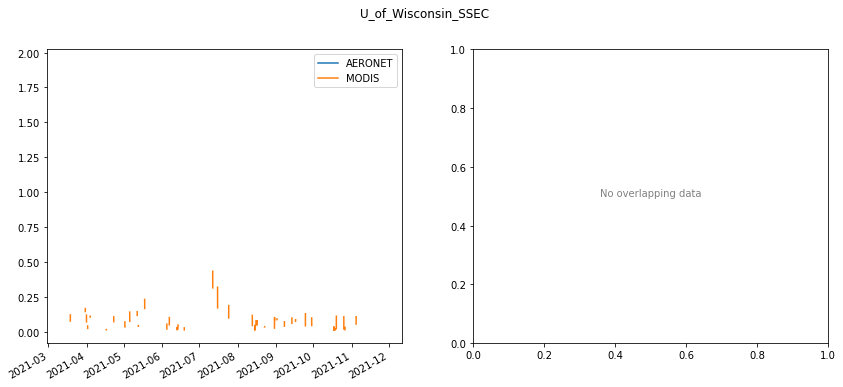

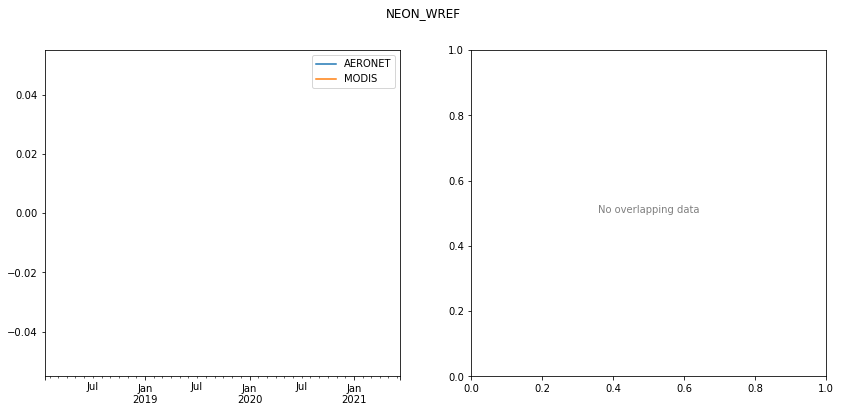

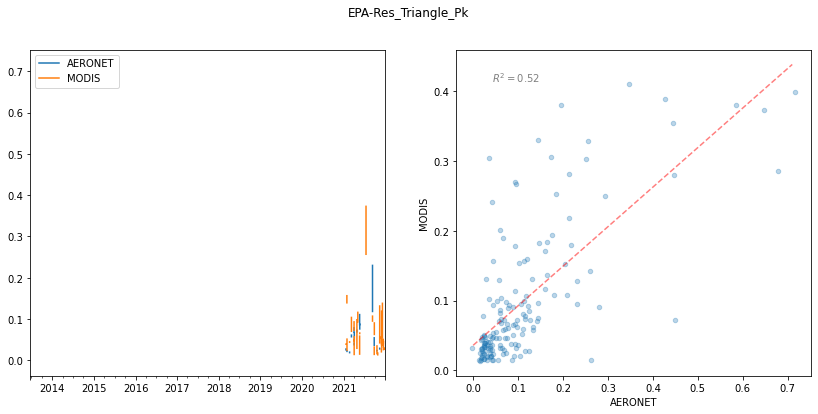

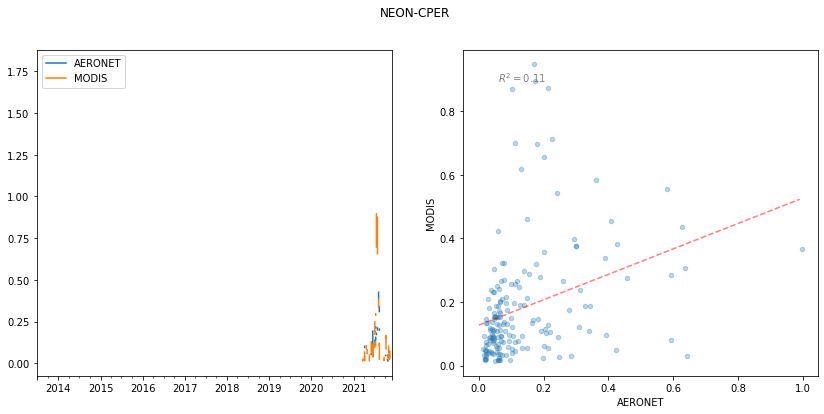

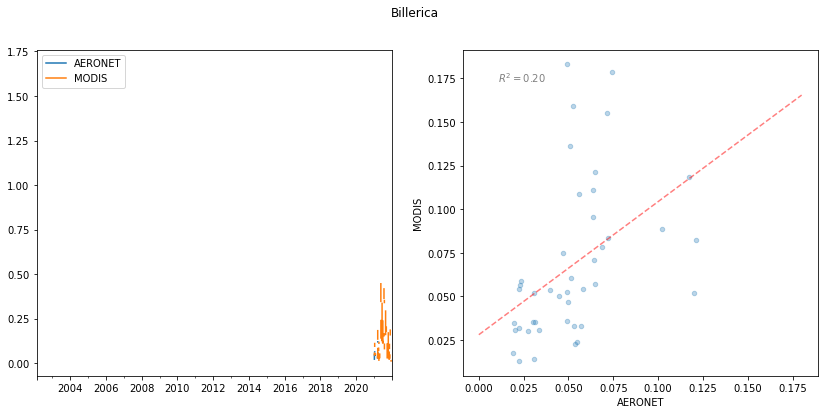

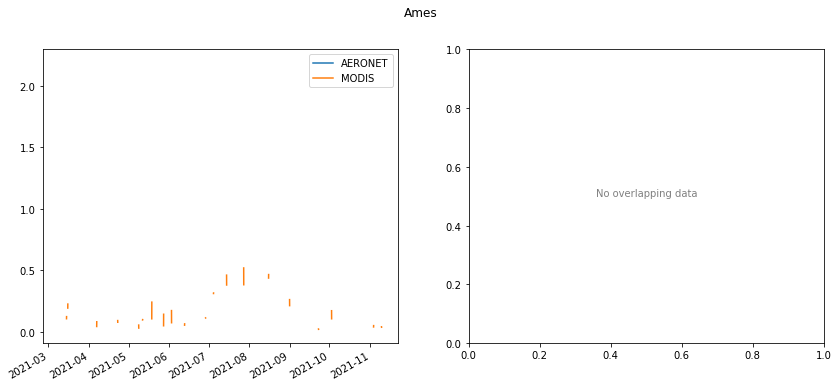

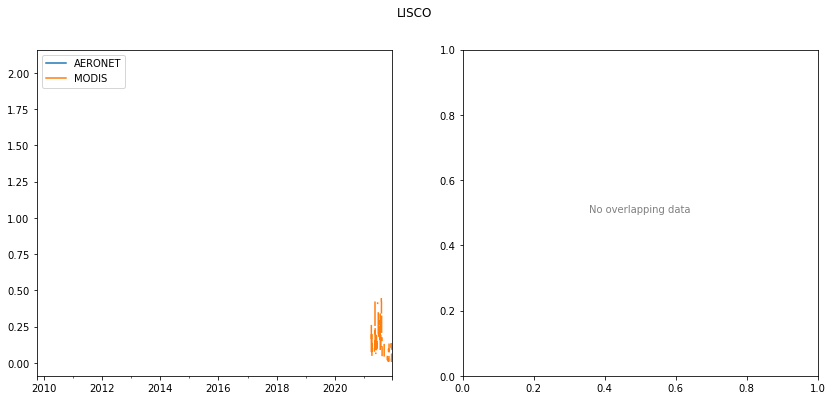

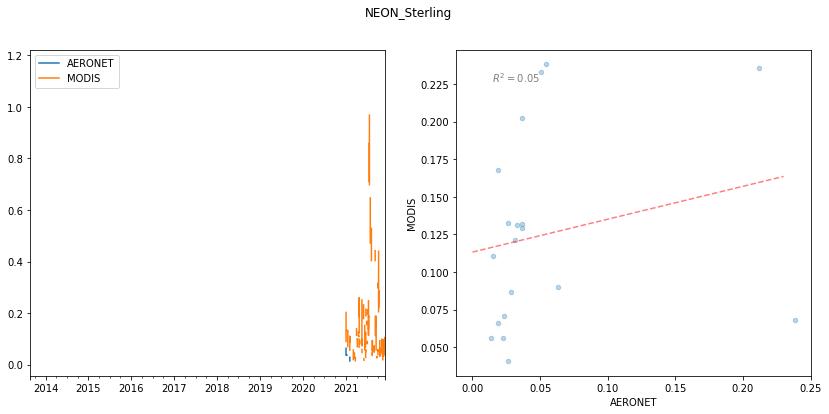

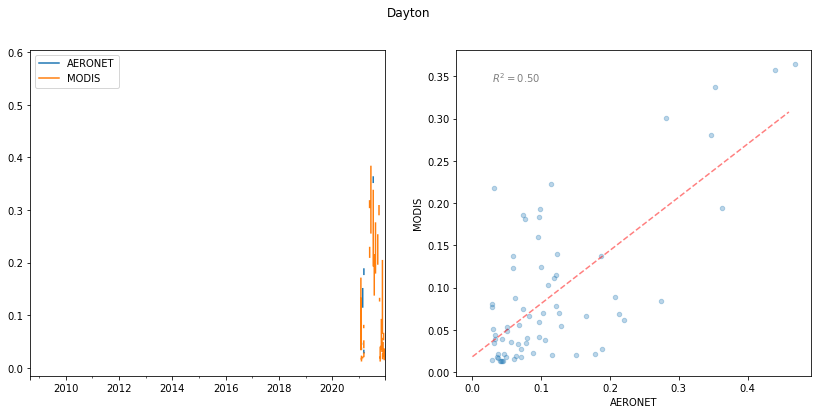

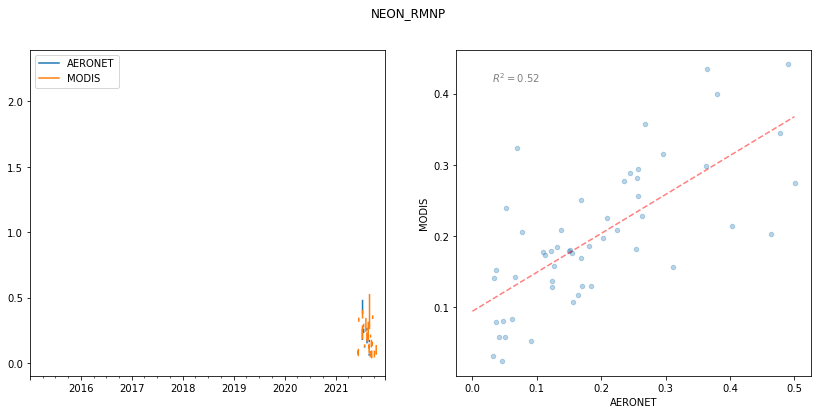

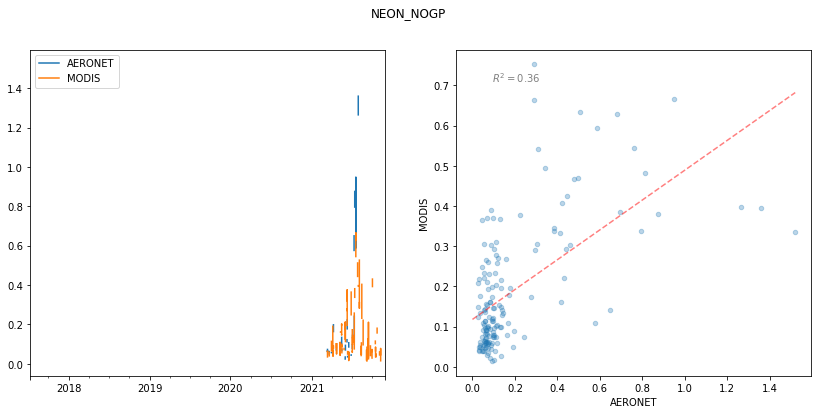

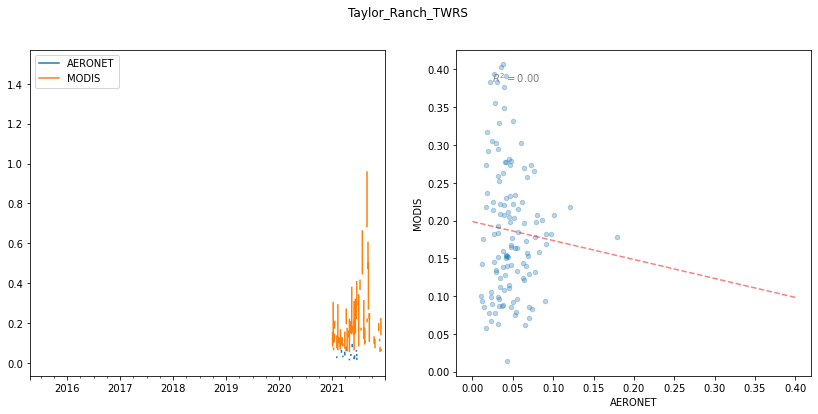

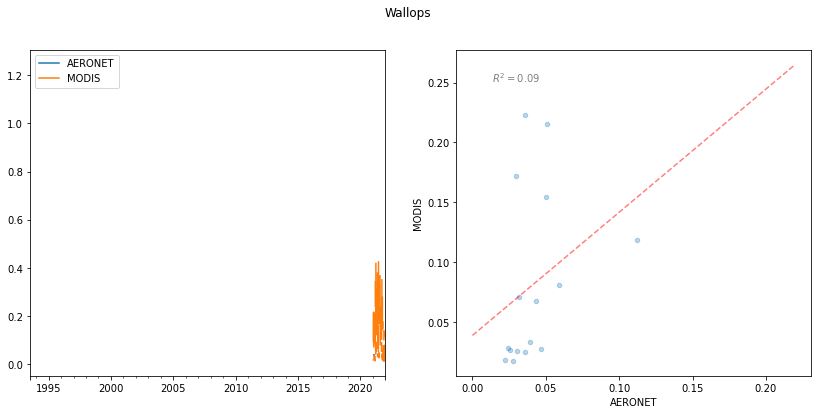

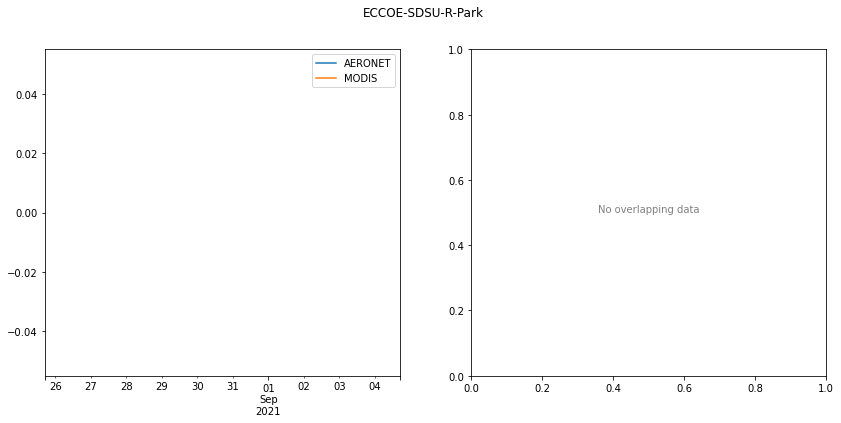

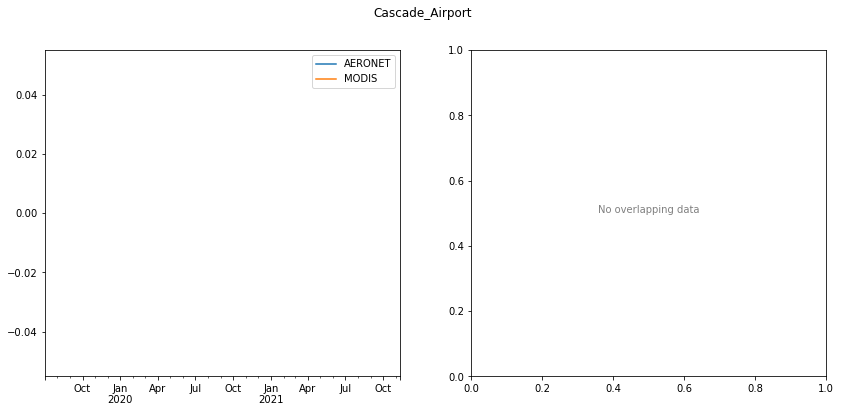

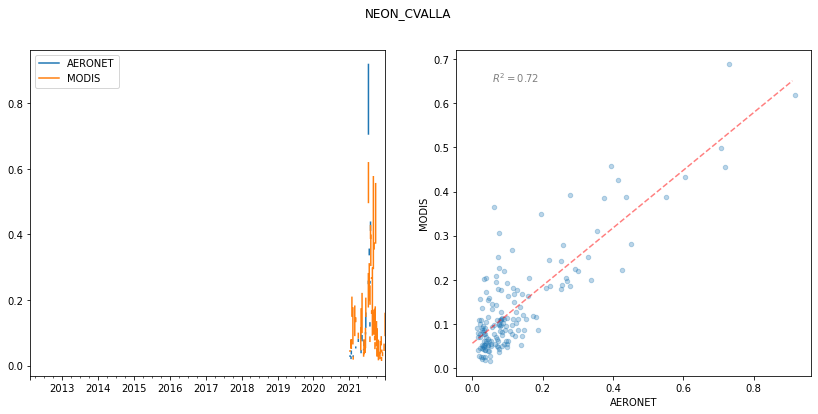

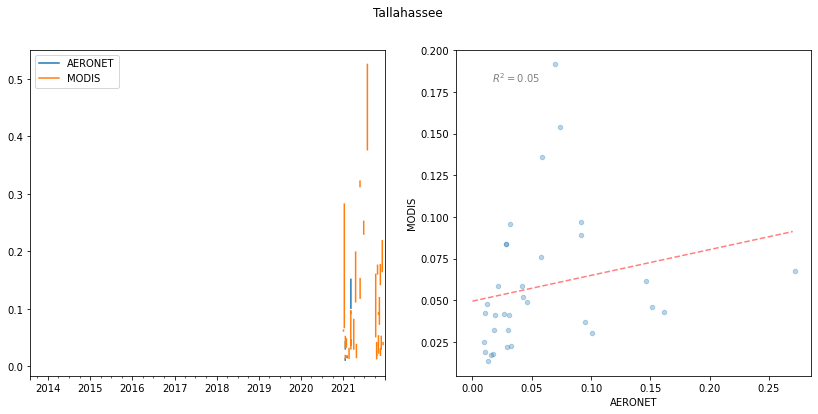

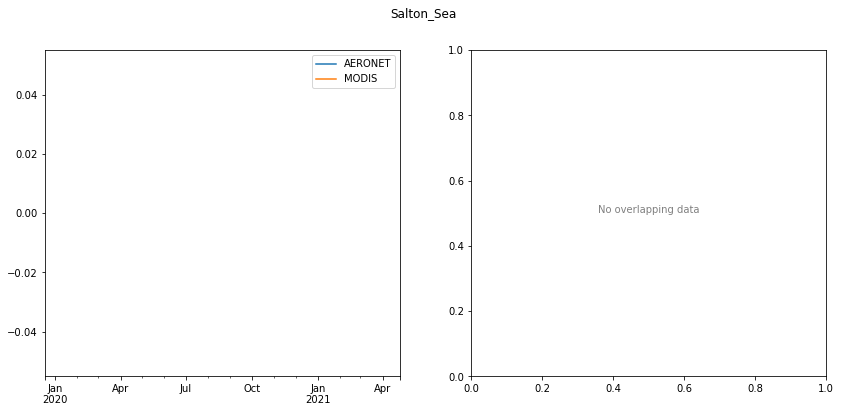

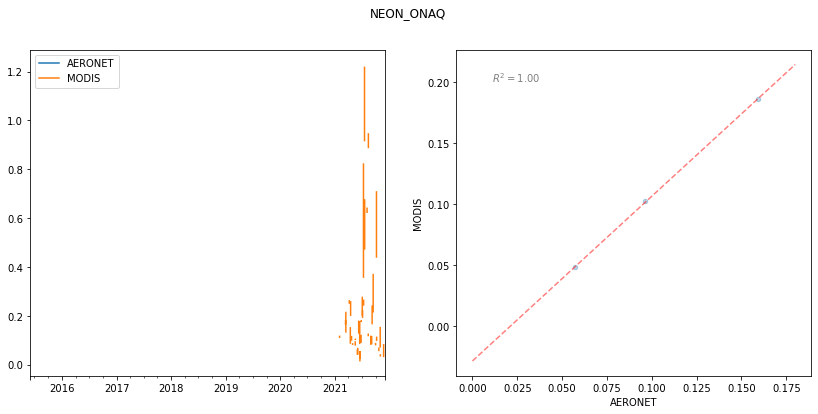

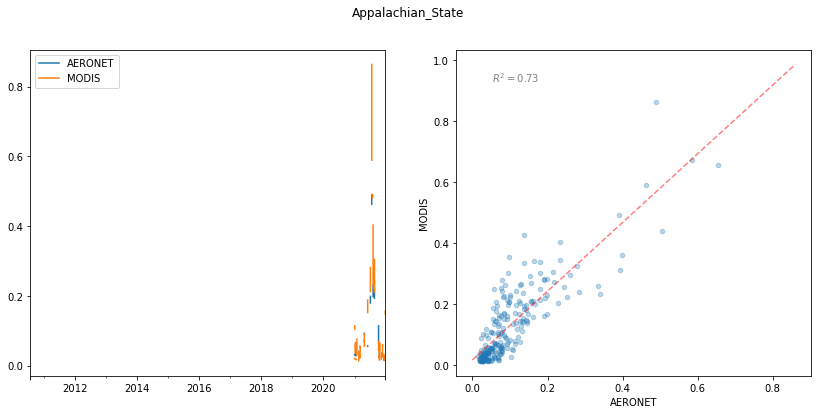

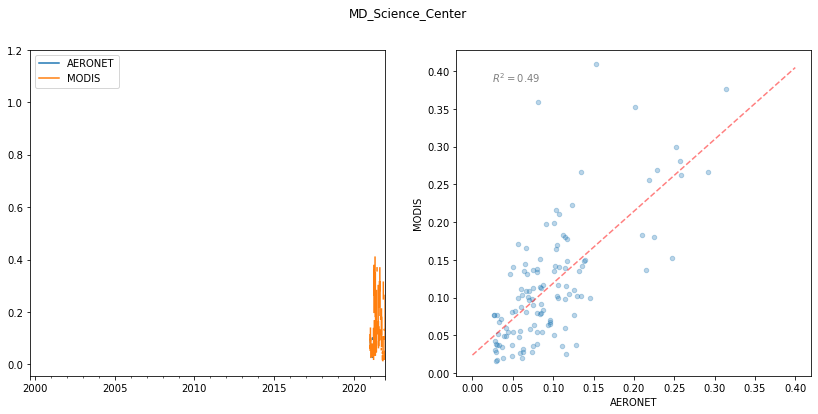

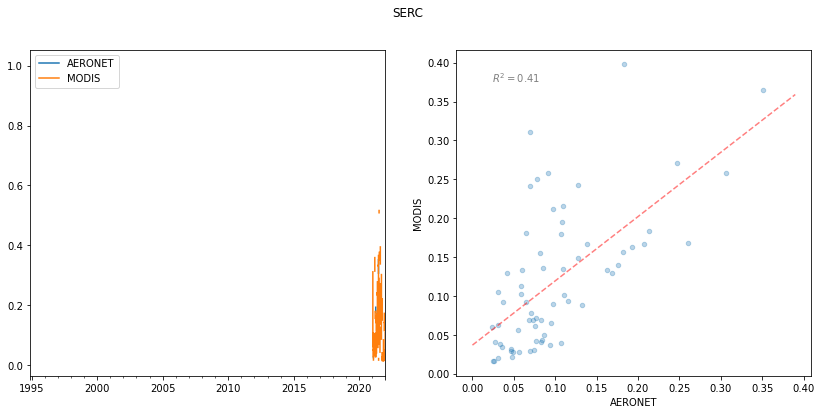

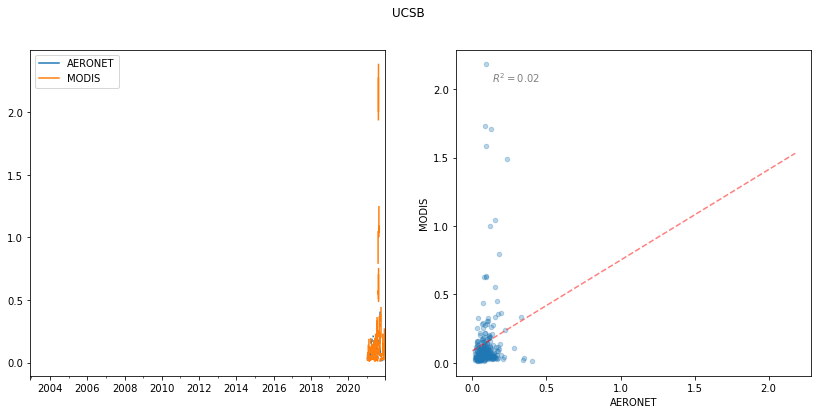

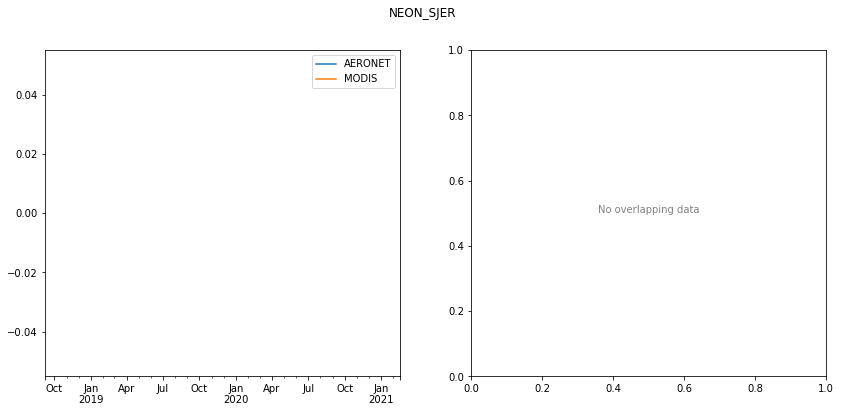

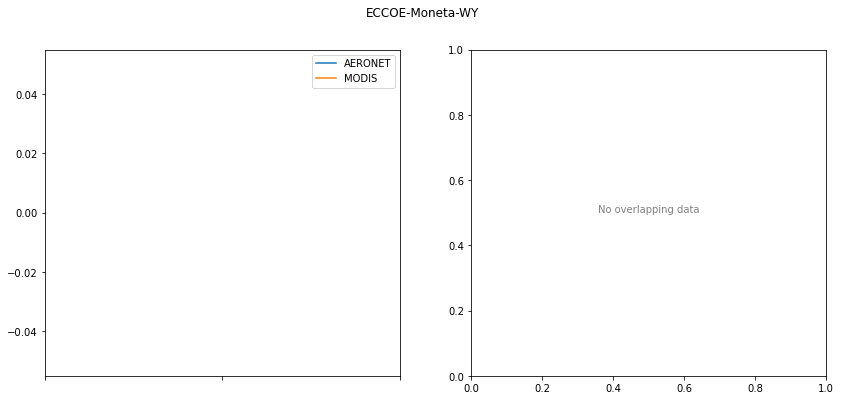

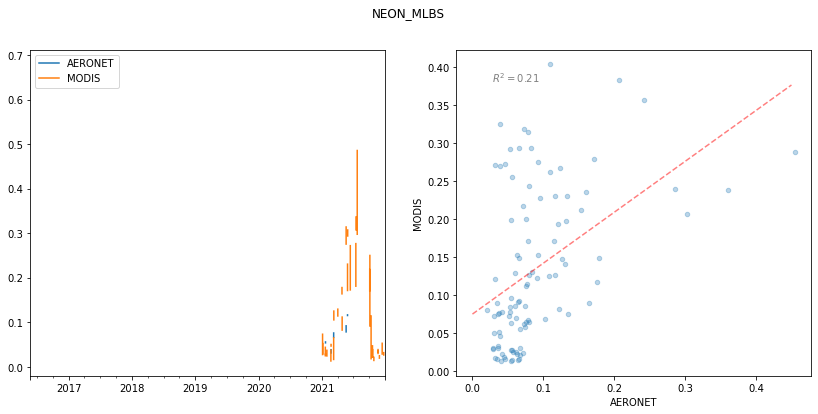

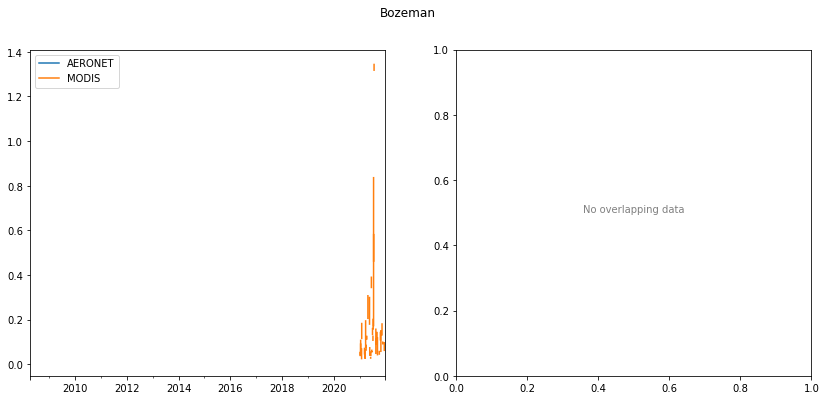

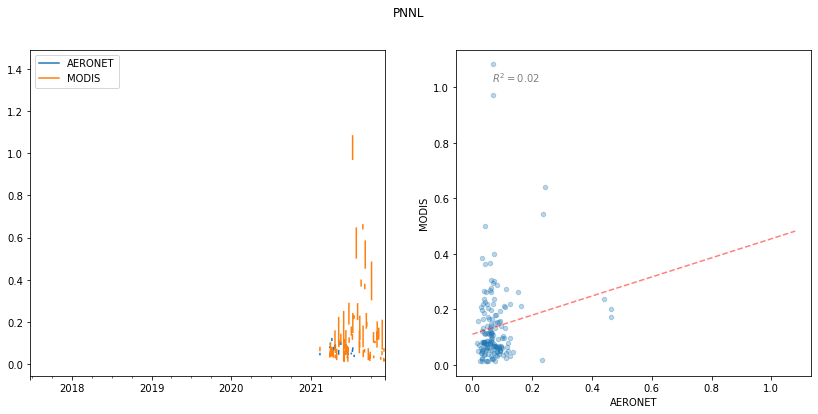

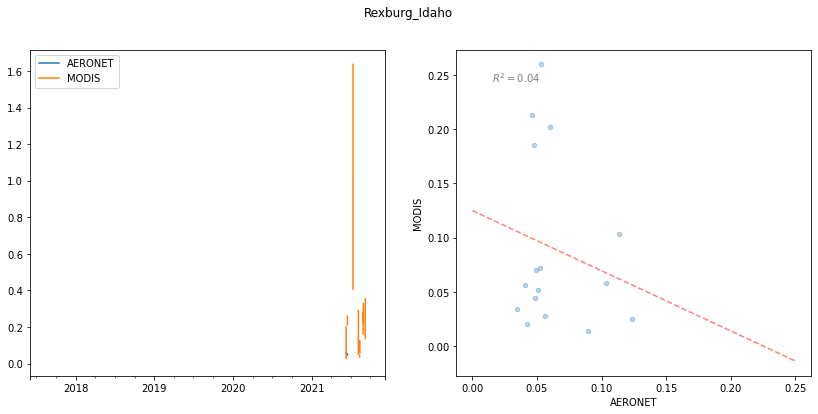

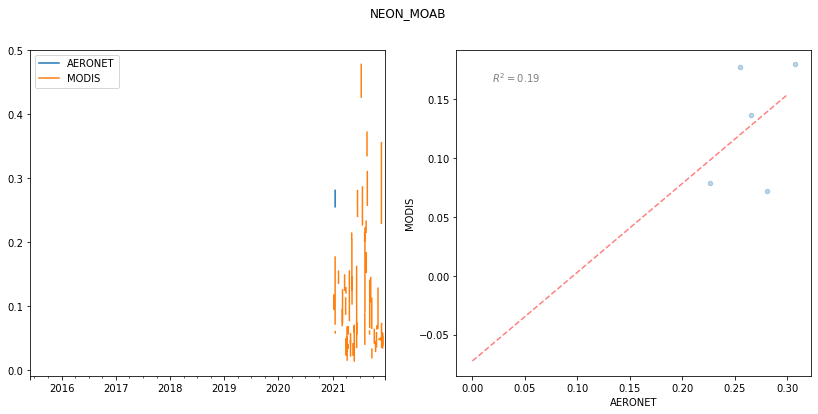

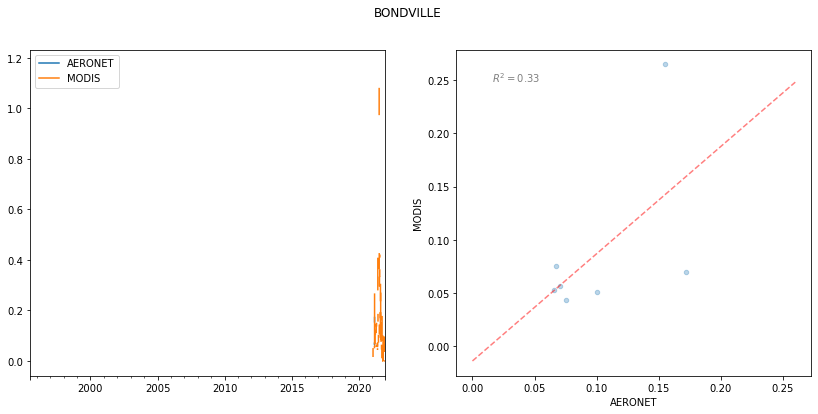

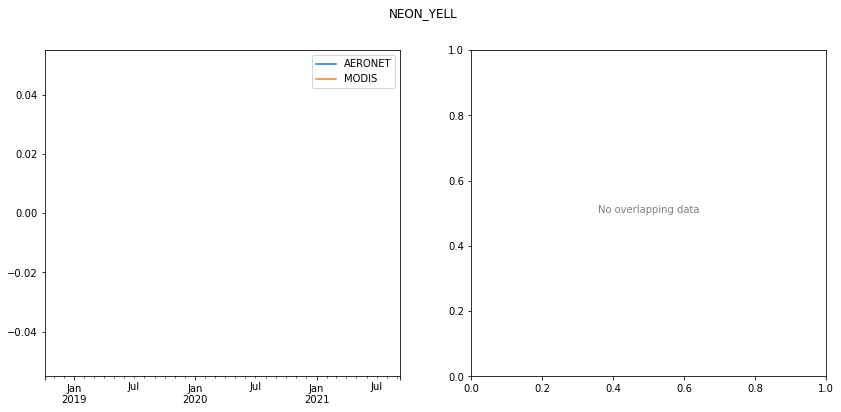

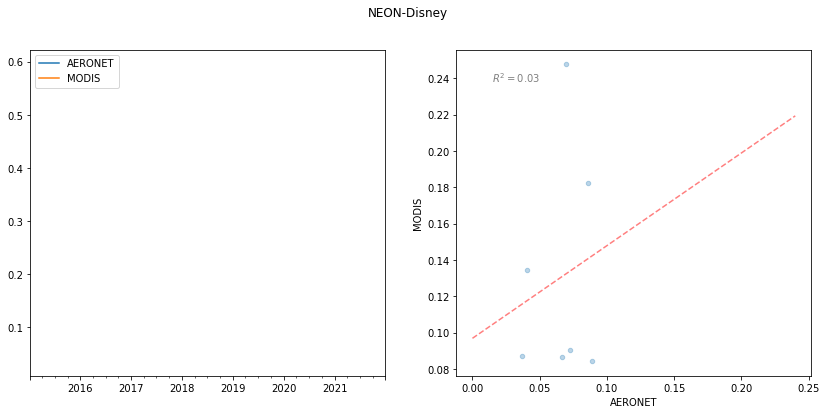

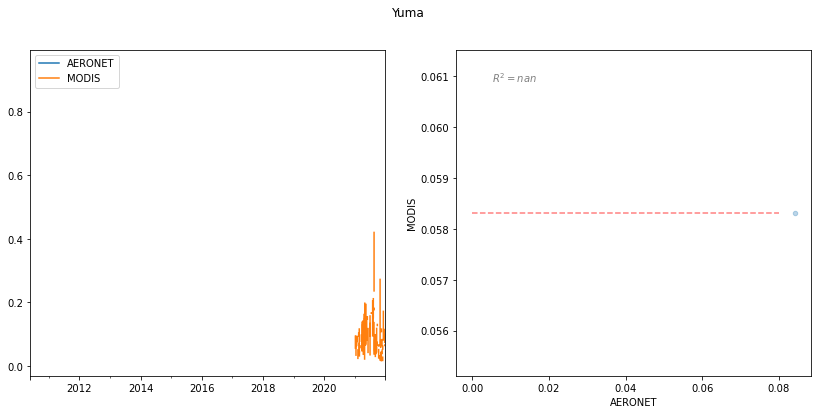

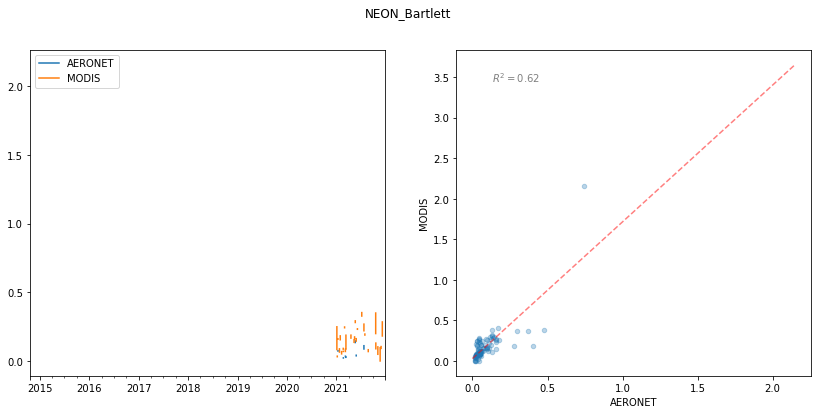

In [11]:
for df in aeronet:
    df = df.compute()
    if '2021' in df.index:
        row = df[['Site_Latitude(Degrees)', 'Site_Longitude(Degrees)']].iloc[0]
        lat, lon = row['Site_Latitude(Degrees)'], row['Site_Longitude(Degrees)']

        modis_location = modis[np.isclose(modis[['Latitude', 'Longitude']], [lat, lon]).any(axis=1)]

    #     fig, ax = plt.subplots(dpi=300)

        hourly_modis = modis_location[['Dates', 'AOD']].set_index('Dates').resample('1h').mean()
        hourly_aeronet = df['AOD_550nm'].resample('1h').mean()

    #     daily_modis.plot(ax=ax, color='green', alpha=0.5)
    #     daily_aeronet.plot(ax=ax, color='red', alpha=0.5)

        compare = pd.concat([hourly_aeronet, hourly_modis], axis=1)
        compare.columns = ['AERONET', 'MODIS']
        # find where there is no MODIS data
        filt = compare['MODIS'].isna()
        # now set the AERNOT data to null so that the graphs are pretty
        compare.loc[filt, 'AERONET'] = np.NaN

        no_na = compare.dropna()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(df['AERONET_Site_Name'].iloc[0])
        compare.plot(ax=ax1)

        if np.any(no_na):
            reg = LinearRegression()
            reg.fit(no_na['AERONET'].values.reshape(-1, 1), no_na['MODIS'].values.reshape(-1, 1))

            x = np.arange(0, no_na.max().max(), 0.01)
            pred = reg.predict(x.reshape(-1, 1))
            r2 = reg.score(no_na['AERONET'].values.reshape(-1, 1), no_na['MODIS'].values.reshape(-1, 1))

            no_na.plot.scatter(x='AERONET', y='MODIS', ax = ax2, alpha=0.3)
            ax2.plot(x, pred, ls='--', alpha=0.5, color='red')
            ax2.text(0.1, 0.9, f'$R^2 = {r2:0.2f}$', transform=ax2.transAxes, color='grey');
        else:
            ax2.text(0.5, 0.5, f'No overlapping data', transform=ax2.transAxes, color='grey', ha='center');

        #     modis_location[['Dates', 'AOD']].plot.scatter(x='Dates', y='AOD', ax=ax, color='green', s=0.5, alpha=0.5)
        #     df[['AOD_550nm','Datetime']].plot.scatter(x='Datetime', y='AOD_550nm', ax=ax, color='red', s=0.5, alpha=0.5)


In [8]:
'2021' in df.index

True

In [16]:
filt = compare['MODIS'].isna()
compare.loc[filt, 'AERONET'] = np.NaN

In [34]:
us_files = pd.read_csv('data/US_aeronet_files.csv')

/usr/local/Caskroom/miniconda/base/envs/pm/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


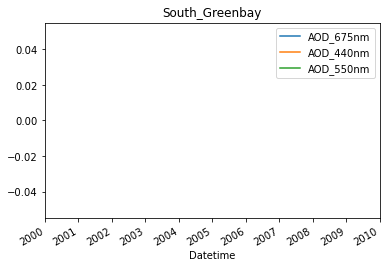

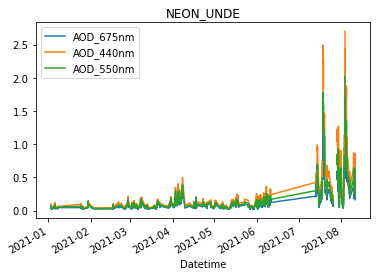

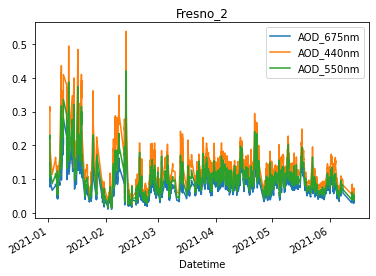

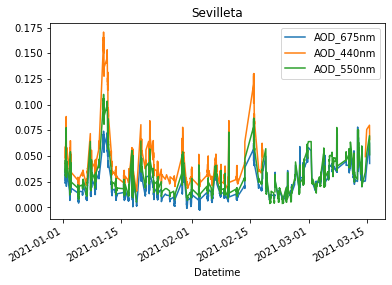

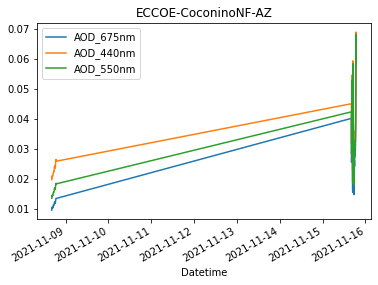

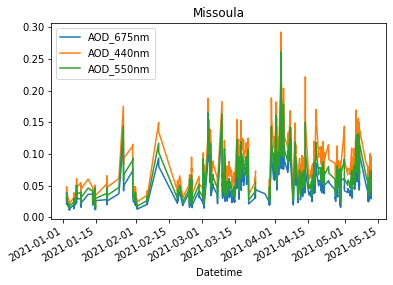

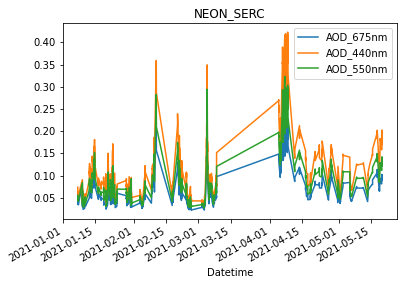

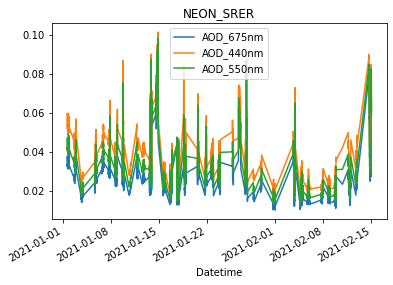

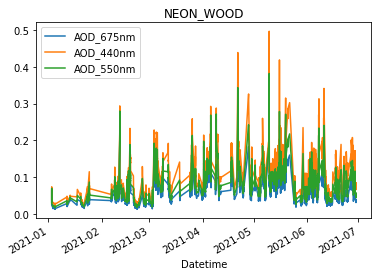

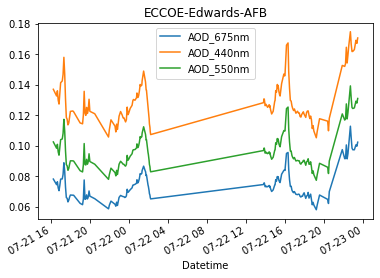

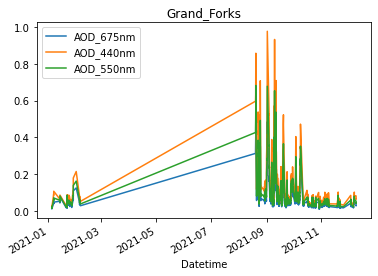

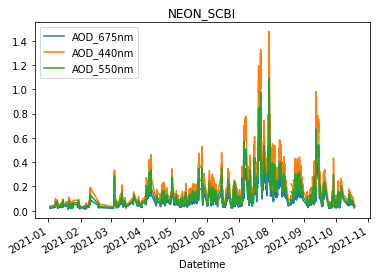

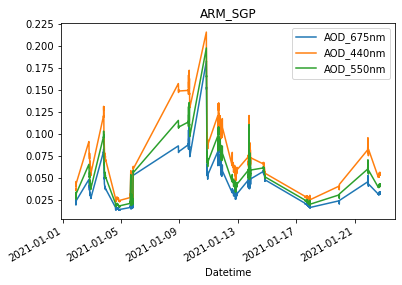

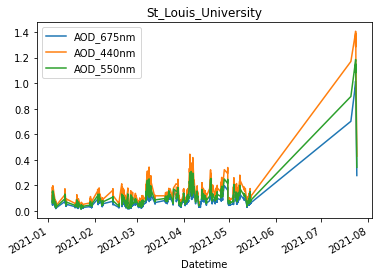

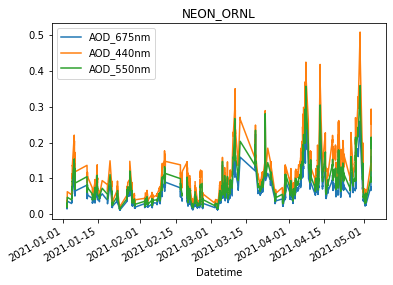

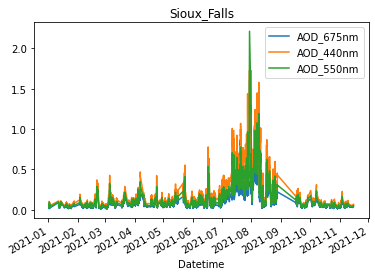

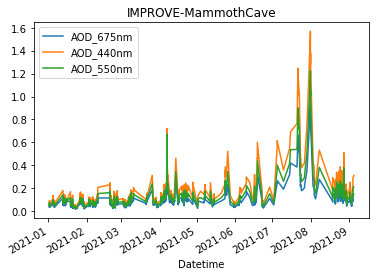

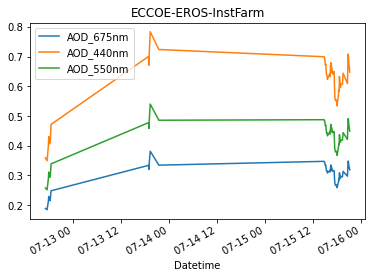

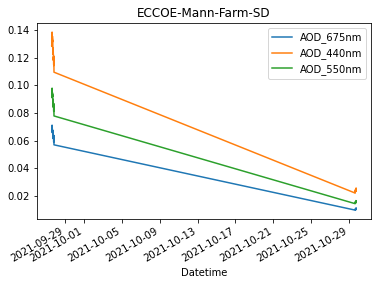

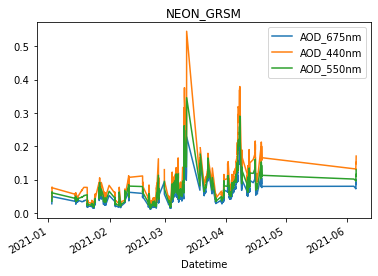

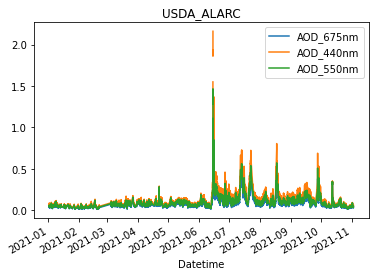

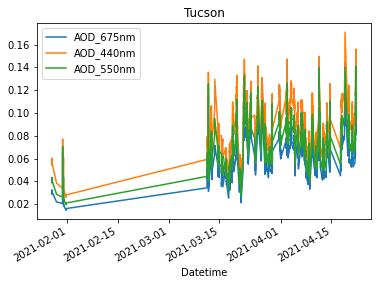

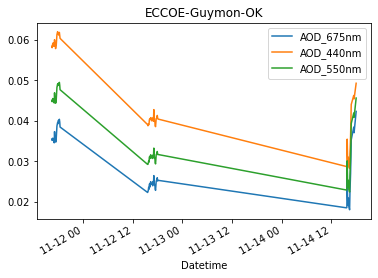

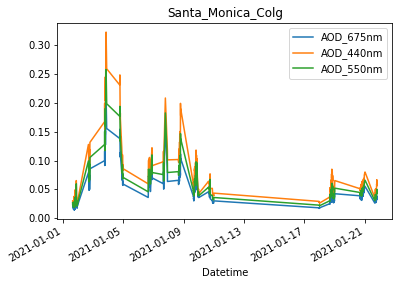

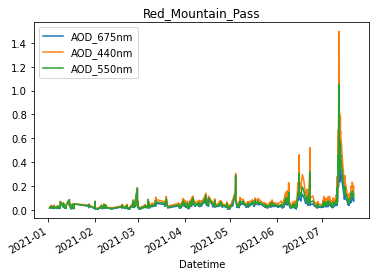

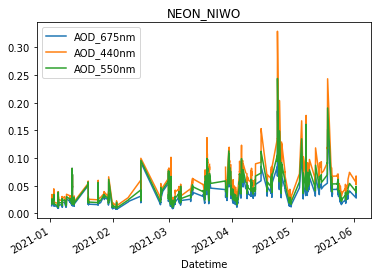

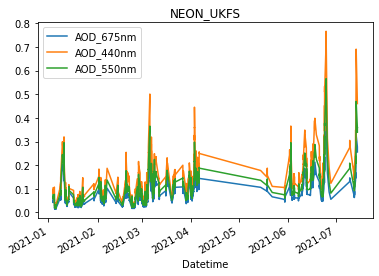

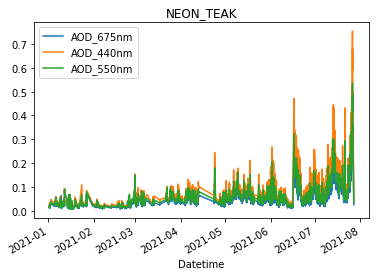

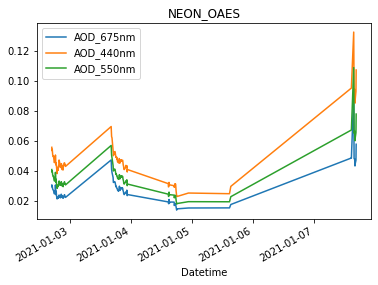

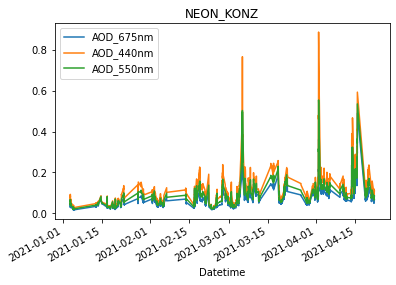

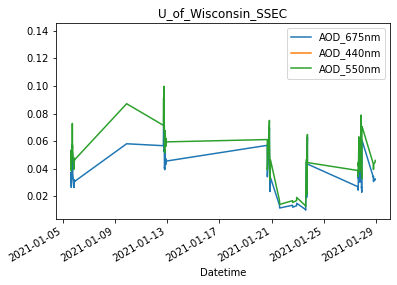

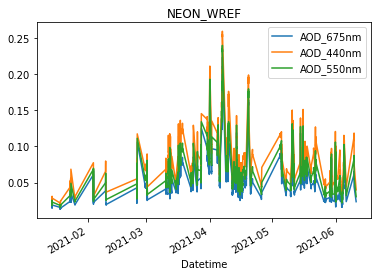

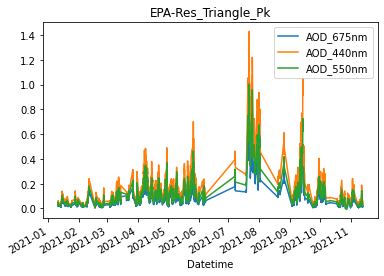

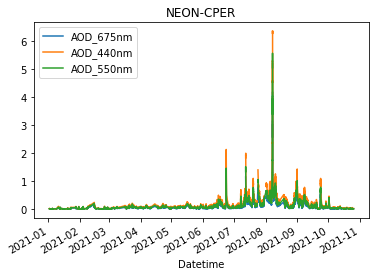

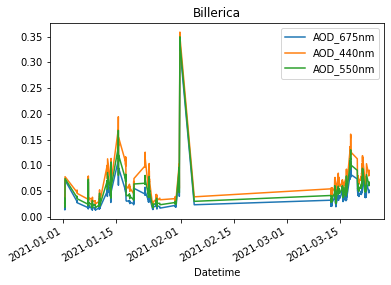

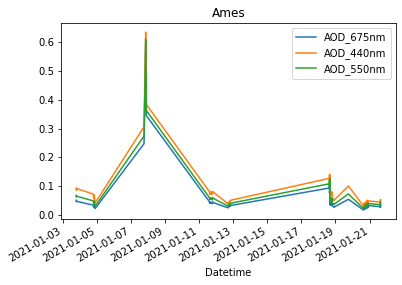

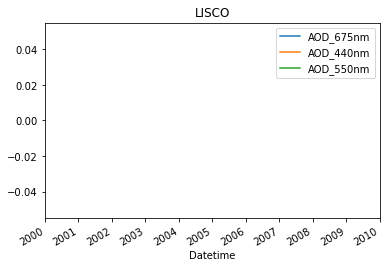

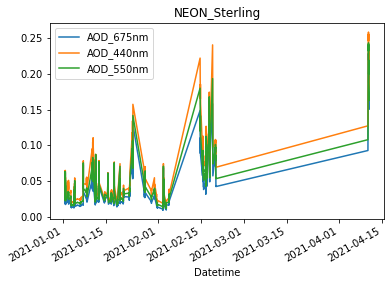

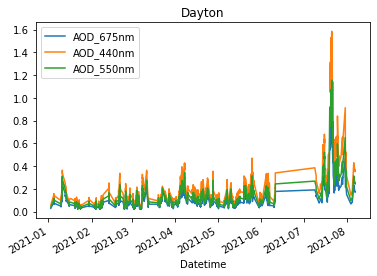

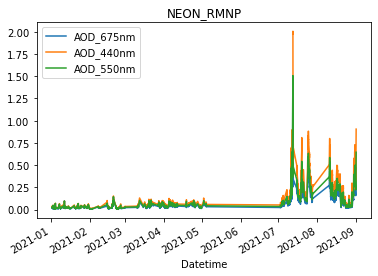

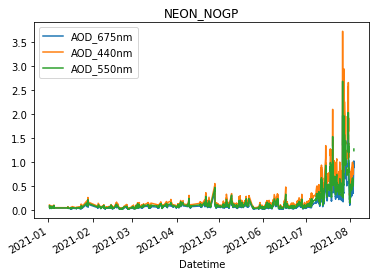

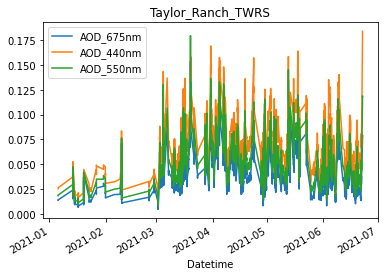

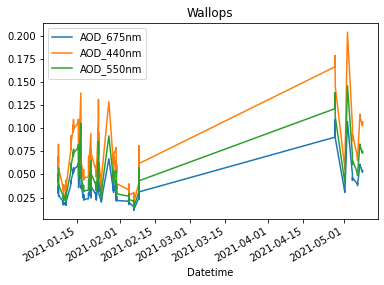

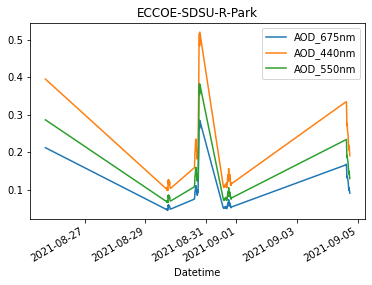

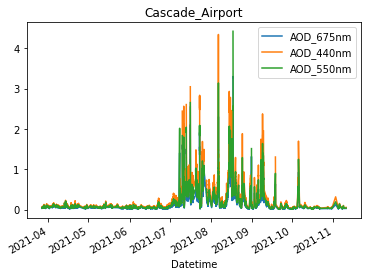

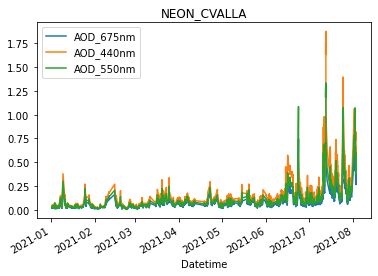

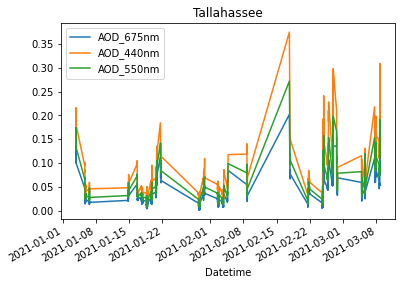

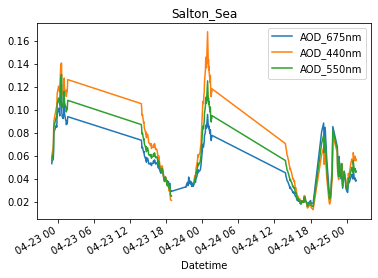

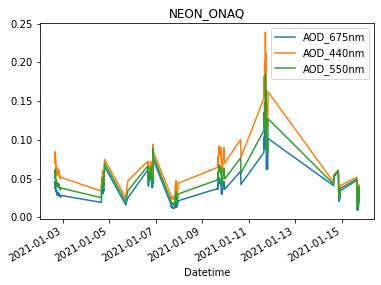

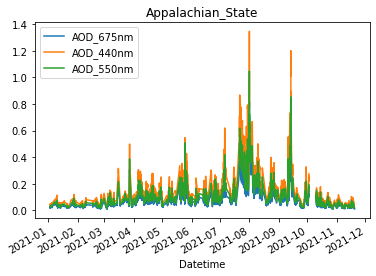

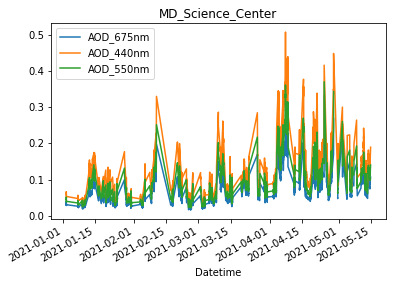

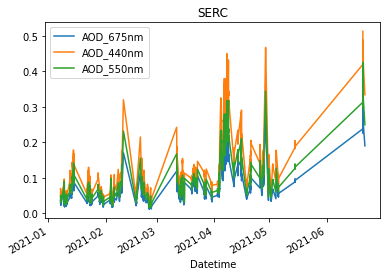

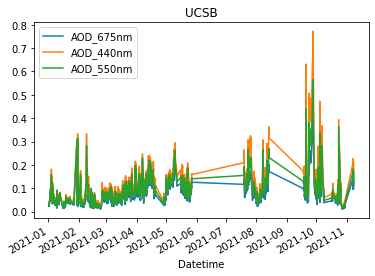

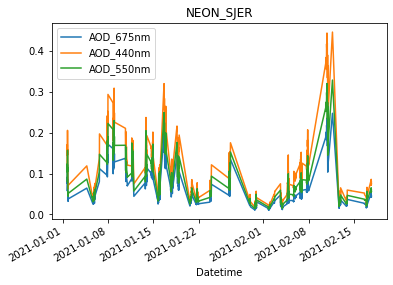

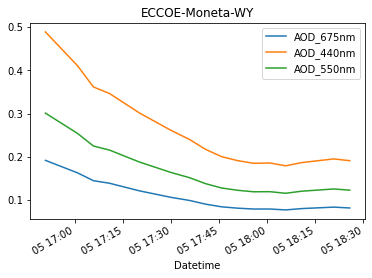

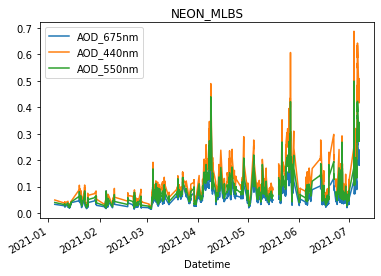

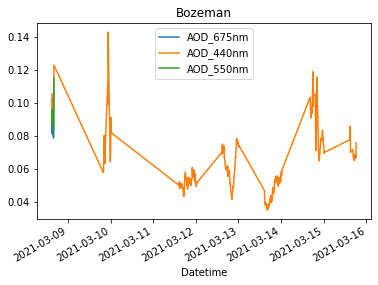

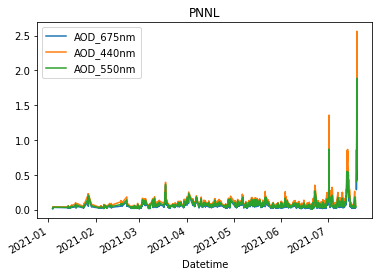

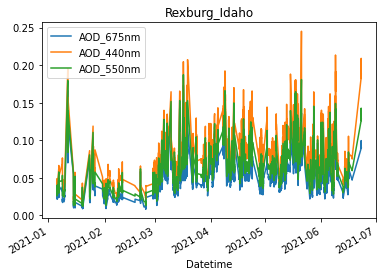

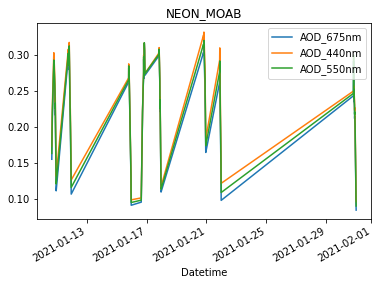

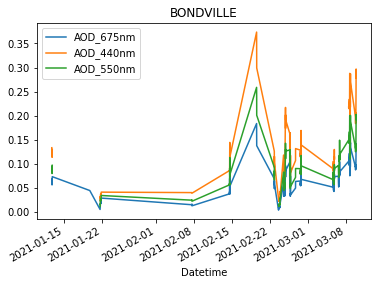

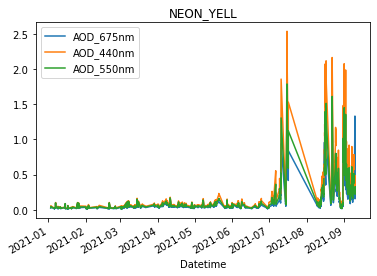

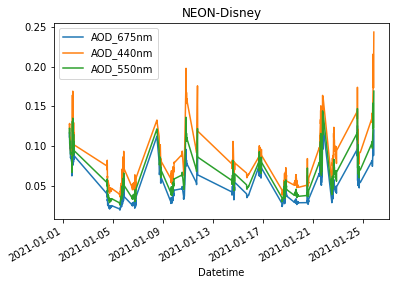

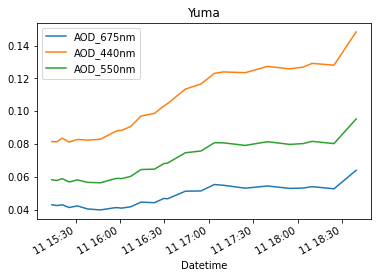

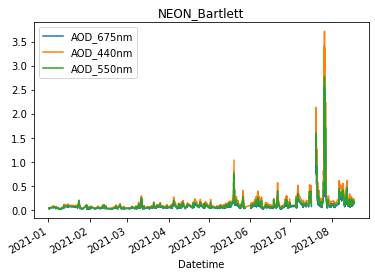

In [70]:
for idx, row in us_files.iterrows():
    df = read_aeronet_csv(row.Files, na_values=["-999.000000"])
    df.set_index('Datetime', inplace=True)
    if '2021' in df.index:
        df.loc['2021':][['AOD_675nm', 'AOD_440nm', 'AOD_550nm']].plot(title=df['AERONET_Site_Name'].iloc[0])

# MODIS-GOES

Regrid xarray stuff [xesmf](https://xesmf.readthedocs.io/en/latest/notebooks/Rectilinear_grid.html)

First, I need to figure out which [MODIS tiles](https://modis-land.gsfc.nasa.gov/MODLAND_grid.html) cover the same location as the GOES data. So I'll pull the top left and bottom right locations from GOES, convert them to lat/lon, then get the MODIS grid point.

In [2]:
def lon_lat_to_modis_tile(lon, lat):
    lon, lat = np.radians((lon, lat))
    
    x = R * lon * np.cos(lat)
    y = R * lat
    
    H = np.floor((x - xmin) / T)
    V = np.floor((ymax - y) / T)
    
    i = (((ymax - y) % T)) / w - 0.5
    j = (((x - xmin) % T)) / w - 0.5
    
    return (H, V, i, j)

def get_projection(ds, variable):
    dat = ds.metpy.parse_cf(variable)
    return dat, dat.metpy.cartopy_crs

def change_xy_to_geospatial(ds, variable):
    dat, geos = get_projection(ds, variable=variable)
    x = dat.x
    y = dat.y

    sat_h = ds.goes_imager_projection.perspective_point_height
    x2 = ds.x * sat_h
    y2 = ds.y * sat_h
    
    ds.attrs["crs"] = geos
    ds = ds.assign_coords(x=ds.x * sat_h, y=ds.y * sat_h)
    
    ds.x.attrs = {'units': 'm',
     'axis': 'X',
     'long_name': 'X sweep in crs',
    }
    ds.y.attrs = {'units': 'm',
     'axis': 'Y',
     'long_name': 'Y sweep in crs',
    }

    return ds

In [3]:
ds = xr.open_dataset('/Volumes/Shores/GOES/AODC/averages/2021/001/0.nc')

In [4]:
ds = change_xy_to_geospatial(ds, 'AOD')
ds

<xarray.Dataset>
Dimensions:                                                 (t: 1, y: 1500,
                                                             x: 2500,
                                                             number_of_image_bounds: 2,
                                                             number_of_sunglint_angle_bounds: 2,
                                                             number_of_LZA_bounds: 2,
                                                             number_of_SZA_bounds: 2,
                                                             land_sensor_bands: 3,
                                                             sea_sensor_bands: 4,
                                                             latitude_bands: 18,
                                                             number_of_latitude_band_bounds: 2)
Coordinates:
  * t                                                       (t) datetime64[ns] ...
  * y                                                       (y) float32 4.588...
  * x                                                       (x) float32 -3.62...
    y_image                                                 float32 0.08624
    x_image                                                 float32 -0.03136
    sunglint_angle                                          float32 40.0
    retrieval_local_zenith_angle                            float32 90.0
    quantitative_local_zenith_angle                         float32 60.0
    retrieval_solar_zenith_angle                            float32 90.0
    quantitative_solar_zenith_angle                         float32 80.0
    aod_product_wavelength                                  float32 0.55
  * latitude_bands                                          (latitude_bands) float32 ...
Dimensions without coordinates: number_of_image_bounds,
                                number_of_sunglint_angle_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                land_sensor_bands, sea_sensor_bands,
                                number_of_latitude_band_bounds
Data variables: (12/60)
    AOD                                                     (t, y, x) float32 ...
    DQF                                                     (t, y, x) float32 ...
    AE1                                                     (t, y, x) float32 ...
    AE2                                                     (t, y, x) float32 ...
    AE_DQF                                                  (t, y, x) float32 ...
    goes_imager_projection                                  (t) float64 ...
    ...                                                      ...
    lat_band_min_aod550_sea                                 (t, latitude_bands) float32 ...
    lat_band_max_aod550_sea                                 (t, latitude_bands) float32 ...
    lat_band_mean_aod550_sea                                (t, latitude_bands) float32 ...
    lat_band_std_dev_aod550_sea                             (t, latitude_bands) float32 ...
    percent_uncorrectable_GRB_errors                        (t) float64 ...
    percent_uncorrectable_L0_errors                         (t) float64 ...
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    time_coverage_start:       2021-01-01T00:51:17.6Z
    time_coverage_end:         2021-01-01T00:53:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        e16f4dd9-0e0b-4a2c-8b68-c33229a50102
    crs:                       +proj=geos +a=6378137.0 +b=6356752.31414 +rf=2...

In [21]:
src_crs = ds.attrs['crs']
lat_lon_proj = ccrs.PlateCarree()

In [22]:
tl_x, tl_y = ds.x.values[0], ds.y.values[0]
br_x, br_y = ds.x.values[-1], ds.y.values[-1]

x0, y0 = lat_lon_proj.transform_point(tl_x, tl_y, src_crs)
x1, y1 = lat_lon_proj.transform_point(br_x, br_y, src_crs)

print((tl_x, tl_y), (x0, y0))
print((br_x, br_y), (x1, y1))

(-3626269.5, 4588198.0) (nan, nan)
(1381770.0, 1584175.9) (-61.90969398915749, 14.638474989478095)


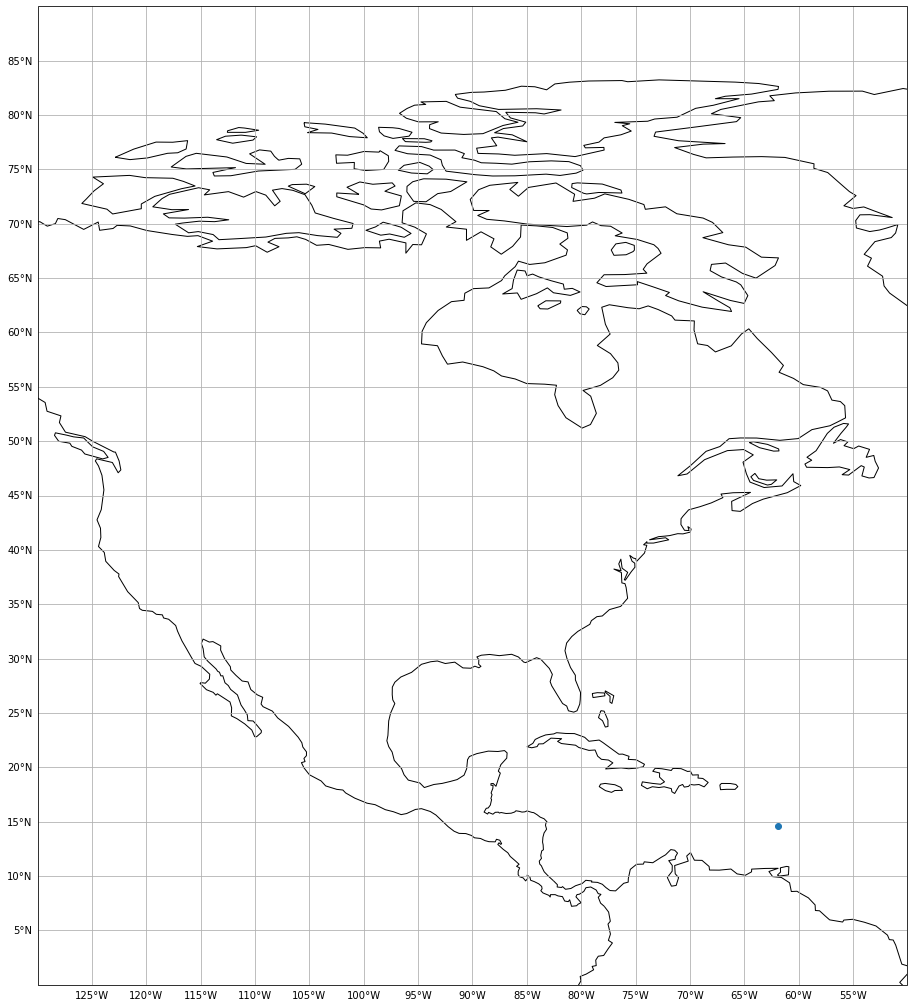

In [23]:
fig, ax = plt.subplots(figsize=(20, 18), subplot_kw=dict(projection=lat_lon_proj))

ax.scatter([x0, x1], [y0, y1])
ax.set_extent((-130.0, -50.0, 0.0, 90.0))
ax.coastlines()
gl = ax.gridlines(draw_labels=True, ylocs=np.arange(0, 90, 5), xlocs=np.arange(-50, -130, -5))
gl.right_labels = False
gl.top_labels = False

In [9]:
ax.get_extent()

(-129.99999999999952, -49.99999999999981, 0.0, 89.99999999999966)

In [10]:
ax.gridlines?

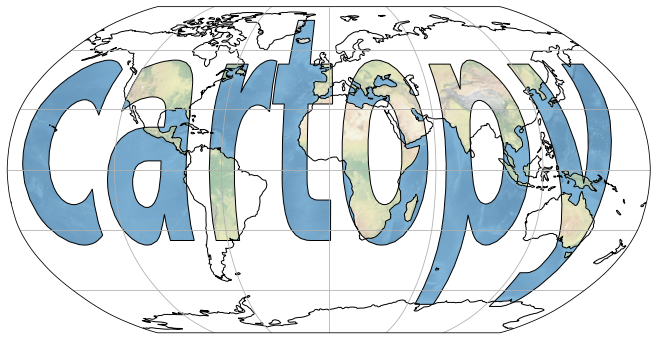

In [26]:
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
from matplotlib.transforms import Affine2D
from matplotlib.patches import PathPatch

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.coastlines()
ax.gridlines()

# generate a matplotlib path representing the word "cartopy"
fp = FontProperties(family='DejaVu Sans', weight='bold')
logo_path = TextPath((-175, -35), 'cartopy',
                                         size=80, prop=fp)
# scale the letters up to sensible longitude and latitude sizes
transform = Affine2D().scale(1, 2).translate(0, 35)

# add a background image
im = ax.stock_img()
# Apply the scale transform and then the map coordinate transform
plate_carree_transform = (
    transform +
                          ccrs.PlateCarree()._as_mpl_transform(ax))

# add the path as a patch, drawing black outlines around the text
patch = PathPatch(logo_path,
                 facecolor='none', edgecolor='black',
                 transform=plate_carree_transform)
im.set_clip_path(patch)
ax.add_patch(patch)